In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import spacy

from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud

In [2]:
with open('cnn_articles.txt', 'r', encoding='utf8') as f:
  articles = f.read().split('@delimiter')

In [3]:
print(len(articles))
print(articles[0])

92579
 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affairs program for children -- several youngsters in Kabul, Afghanistan, say they are afraid of daily violence and the frequent explosions in their war-torn country.

In response, Sedwill says: "Here in Kabul, and other big cities actually, there are very few of these bombs. The children are probably safer here than they would be in London, New York or Glasgow or many other cities.

"Most children can go about their lives in safety. It's a very family-oriented society. So it is a little bit like a city of villages," he added.

A U.N. report released earlier this year seems to contradict Sedwill's assessment.

The February report, by the special representative for children and armed confli

In [4]:
DATASET_SIZE = 20000
dataset = articles[:DATASET_SIZE]

In [5]:
nlp = spacy.blank('en')

def basic_filter(tokenized_doc):
    return [t.text for t in tokenized_doc if \
            not t.is_punct and \
            not t.is_space and \
            t.is_alpha]

In [6]:
NUM_PROCESS = 4

In [7]:
%%time
tokenized_articles = list(map(basic_filter, nlp.pipe(dataset, n_process=NUM_PROCESS))) #nlp.pipe is used to tokenize parallelly

CPU times: total: 1min 51s
Wall time: 2min 4s


In [8]:
print(tokenized_articles[0])

['Children', 'in', 'war', 'ravaged', 'Afghanistan', 'are', 'safer', 'than', 'those', 'growing', 'up', 'in', 'London', 'or', 'New', 'York', 'NATO', 'top', 'civilian', 'envoy', 'says', 'Mark', 'Sedwill', 'the', 'senior', 'civilian', 'representative', 'for', 'NATO', 'made', 'the', 'comments', 'on', 'an', 'episode', 'of', 'CBBC', 'Newsround', 'which', 'is', 'airing', 'Monday', 'In', 'the', 'show', 'a', 'BBC', 'current', 'affairs', 'program', 'for', 'children', 'several', 'youngsters', 'in', 'Kabul', 'Afghanistan', 'say', 'they', 'are', 'afraid', 'of', 'daily', 'violence', 'and', 'the', 'frequent', 'explosions', 'in', 'their', 'war', 'torn', 'country', 'In', 'response', 'Sedwill', 'says', 'Here', 'in', 'Kabul', 'and', 'other', 'big', 'cities', 'actually', 'there', 'are', 'very', 'few', 'of', 'these', 'bombs', 'The', 'children', 'are', 'probably', 'safer', 'here', 'than', 'they', 'would', 'be', 'in', 'London', 'New', 'York', 'or', 'Glasgow', 'or', 'many', 'other', 'cities', 'Most', 'children

In [9]:
NUM_TOPICS = 20

In [10]:
%%time

#This builds a word <-> id mapping
dictionary = corpora.Dictionary(tokenized_articles)
sample_token = 'news'
print(f'Id for \'{sample_token}\' token: {dictionary.token2id[sample_token]}')

Id for 'news' token: 1039
CPU times: total: 9.83 s
Wall time: 9.93 s


In [11]:
%%time
corpus_bow = [dictionary.doc2bow(article) for article in tokenized_articles]

CPU times: total: 6.19 s
Wall time: 6.19 s


In [16]:
%%time
lda_model = models.LdaModel(corpus=corpus_bow, num_topics=NUM_TOPICS, id2word=dictionary, random_state=1)

CPU times: total: 59.8 s
Wall time: 1min 8s


In [17]:
lda_model.print_topics()

[(0,
  '0.068*"the" + 0.041*"of" + 0.027*"and" + 0.025*"to" + 0.025*"in" + 0.023*"a" + 0.013*"is" + 0.009*"for" + 0.008*"that" + 0.008*"The"'),
 (1,
  '0.046*"the" + 0.031*"I" + 0.030*"a" + 0.028*"to" + 0.022*"and" + 0.019*"in" + 0.017*"of" + 0.012*"was" + 0.012*"it" + 0.012*"that"'),
 (2,
  '0.064*"the" + 0.030*"of" + 0.025*"to" + 0.023*"and" + 0.020*"in" + 0.017*"a" + 0.011*"that" + 0.011*"is" + 0.009*"Syria" + 0.008*"for"'),
 (3,
  '0.038*"the" + 0.032*"to" + 0.029*"and" + 0.029*"of" + 0.024*"a" + 0.017*"that" + 0.016*"in" + 0.013*"is" + 0.010*"are" + 0.009*"for"'),
 (4,
  '0.069*"the" + 0.030*"of" + 0.029*"to" + 0.024*"and" + 0.021*"in" + 0.019*"a" + 0.015*"said" + 0.011*"The" + 0.010*"that" + 0.009*"on"'),
 (5,
  '0.060*"the" + 0.031*"in" + 0.029*"of" + 0.028*"to" + 0.027*"and" + 0.021*"a" + 0.014*"said" + 0.011*"that" + 0.011*"The" + 0.008*"is"'),
 (6,
  '0.054*"the" + 0.033*"to" + 0.030*"of" + 0.027*"in" + 0.026*"and" + 0.025*"a" + 0.012*"said" + 0.011*"that" + 0.009*"The" + 0.0

Here we can see the topics are mostly dominated by stop words, which is not good

## Improving the model

In [18]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def improved_filter(tokenized_doc):
    return [t.lemma_ for t in tokenized_doc if
            t.is_alpha and \
            not t.is_punct and \
            not t.is_space and \
            not t.is_stop and \
            t.pos_ in ['NOUN', 'VERB', 'ADJ']]

In [19]:
%%time
tokenized_articles_w_pos = list(map(improved_filter, nlp.pipe(dataset, n_process=NUM_PROCESS)))
dictionary_w_pos = corpora.Dictionary(tokenized_articles_w_pos)
corpus_bow_w_pos = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

CPU times: total: 2min 46s
Wall time: 6min 51s


In [20]:
%%time
lda_model = models.LdaModel(corpus=corpus_bow_w_pos, num_topics=NUM_TOPICS, id2word=dictionary_w_pos, random_state=1)

CPU times: total: 22.7 s
Wall time: 22.8 s


In [21]:
lda_model.print_topics()

[(0,
  '0.020*"say" + 0.012*"war" + 0.011*"attack" + 0.010*"group" + 0.010*"force" + 0.009*"kill" + 0.009*"country" + 0.009*"people" + 0.009*"military" + 0.008*"government"'),
 (1,
  '0.021*"say" + 0.012*"study" + 0.009*"cancer" + 0.008*"doctor" + 0.008*"patient" + 0.007*"year" + 0.007*"test" + 0.007*"disease" + 0.007*"find" + 0.006*"people"'),
 (2,
  '0.020*"law" + 0.016*"say" + 0.013*"right" + 0.013*"court" + 0.010*"year" + 0.010*"state" + 0.007*"gun" + 0.007*"case" + 0.007*"country" + 0.006*"immigration"'),
 (3,
  '0.042*"say" + 0.011*"military" + 0.009*"official" + 0.006*"report" + 0.006*"tell" + 0.006*"statement" + 0.005*"russian" + 0.005*"government" + 0.005*"year" + 0.004*"israeli"'),
 (4,
  '0.014*"say" + 0.009*"year" + 0.007*"new" + 0.006*"world" + 0.006*"site" + 0.006*"time" + 0.006*"design" + 0.006*"find" + 0.005*"video" + 0.005*"people"'),
 (5,
  '0.033*"say" + 0.024*"government" + 0.012*"country" + 0.012*"people" + 0.010*"report" + 0.010*"protest" + 0.008*"group" + 0.008*"

"say" occurs a lot so maybe we can add it our stop words list

In [22]:
# One thing we can try is filtering out rare and common tokens
len(dictionary_w_pos)

39259

In [23]:
dictionary_w_pos.filter_extremes(no_below=5, no_above=0.5) #no_below tells us that word should appear atleast 5 times in document and no_above tells us the maximum percentage that a token can appear in across documents 

In [24]:
len(dictionary_w_pos)

18167

In [25]:
corpus_bow_w_pos_filtered = [dictionary_w_pos.doc2bow(article) for article in tokenized_articles_w_pos]

In [26]:
%%time
lda_model = models.ldamodel.LdaModel(corpus=corpus_bow_w_pos_filtered,
                                     id2word=dictionary_w_pos,
                                     num_topics=NUM_TOPICS,
                                     passes=10,
                                     alpha='auto', #prior on document topic distribution
                                     eta='auto', #prior on topic word distribution
                                     random_state=1)

CPU times: total: 3min 16s
Wall time: 3min 17s


In [27]:
lda_model.print_topics()

[(0,
  '0.014*"vote" + 0.012*"president" + 0.012*"election" + 0.011*"state" + 0.010*"campaign" + 0.010*"political" + 0.009*"candidate" + 0.008*"party" + 0.007*"issue" + 0.007*"voter"'),
 (1,
  '0.041*"woman" + 0.038*"child" + 0.033*"school" + 0.025*"student" + 0.016*"girl" + 0.013*"young" + 0.012*"parent" + 0.008*"kid" + 0.008*"college" + 0.008*"education"'),
 (2,
  '0.023*"court" + 0.021*"case" + 0.021*"charge" + 0.012*"arrest" + 0.011*"attorney" + 0.010*"trial" + 0.010*"prison" + 0.010*"prosecutor" + 0.010*"crime" + 0.009*"sentence"'),
 (3,
  '0.012*"world" + 0.009*"city" + 0.008*"history" + 0.008*"today" + 0.008*"building" + 0.007*"place" + 0.007*"find" + 0.007*"century" + 0.007*"african" + 0.006*"site"'),
 (4,
  '0.014*"country" + 0.011*"russian" + 0.011*"nuclear" + 0.009*"official" + 0.009*"international" + 0.008*"military" + 0.008*"weapon" + 0.007*"talk" + 0.007*"leader" + 0.007*"world"'),
 (5,
  '0.013*"flight" + 0.013*"plane" + 0.013*"report" + 0.011*"area" + 0.010*"storm" + 0.

In [28]:
print(lda_model.alpha)
print(lda_model.eta)

[0.0880449  0.09308932 0.0882647  0.08708008 0.0683639  0.07707389
 0.0876482  0.03740351 0.13078432 0.06577628 0.14571212 0.08143422
 0.1028698  0.08747275 0.08284138 0.08736005 0.20973945 0.05817978
 0.0709006  0.08572508]
[0.09793429 0.05842863 0.0486964  ... 0.03962184 0.03962184 0.03962184]


In [29]:
article_idx = 0
print(dataset[article_idx][:300])

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa


In [30]:
# Return topic distribution for an article sorted by probability.
topics = sorted(lda_model.get_document_topics(corpus_bow_w_pos_filtered[article_idx]), key=lambda tup: tup[1])[::-1]
topics

[(19, 0.46470758),
 (1, 0.28492627),
 (8, 0.0785849),
 (10, 0.052399322),
 (9, 0.0449286),
 (17, 0.036582306),
 (15, 0.02979674)]

In [31]:
lda_model.show_topic(topics[0][0])

[('attack', 0.024240738),
 ('military', 0.01866761),
 ('kill', 0.01529186),
 ('force', 0.014895066),
 ('group', 0.014072484),
 ('official', 0.012632938),
 ('security', 0.011711932),
 ('government', 0.011017836),
 ('war', 0.010021021),
 ('report', 0.00842038)]

In [32]:
lda_model.show_topic(topics[1][0])

[('woman', 0.04092454),
 ('child', 0.03842432),
 ('school', 0.033228558),
 ('student', 0.024881968),
 ('girl', 0.015986377),
 ('young', 0.012622201),
 ('parent', 0.012496808),
 ('kid', 0.008487058),
 ('college', 0.007951368),
 ('education', 0.007824392)]

In [33]:
def get_top_topics(article_idx, min_topic_prob):

  # Sort from highest to lowest topic probability.
  topic_prob_pairs = sorted(lda_model.get_document_topics(corpus_bow_w_pos_filtered[article_idx],
                                                          minimum_probability=min_topic_prob),
                            key=lambda tup: tup[1])[::-1]

  word_prob_pairs = [lda_model.show_topic(pair[0]) for pair in topic_prob_pairs]
  topic_words = [[pair[0] for pair in collection] for collection in word_prob_pairs]

  data = {
      'Major Topics': topic_prob_pairs,
      'Topic Words': topic_words
  }

  return pd.DataFrame(data)


In [34]:
pd.set_option('max_colwidth', 600)
snippet_length = 300
min_topic_prob = 0.25

article_idx = 1
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The Hard Rock Cafe franchise, famed for its rock'n'roll memorabilia, is expanding its reach into hotels and casinos -- but its chief executive says the brand will remain "special."

"We don't want to be in every street corner, in every city of the UK," Hard Rock's Hamish Dodds told CNN.

"We wa


,Major Topics,Topic Words
0,"(18, 0.2727098)","[food, hotel, room, good, restaurant, travel, offer, local, eat, beach]"


In [35]:
article_idx = 10
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget prop


,Major Topics,Topic Words
0,"(12, 0.7599898)","[government, money, pay, work, country, need, job, business, economic, plan]"


In [36]:
article_idx = 100
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- A tip led to Wednesday's arrest in Louisiana of a suspected serial bank robber dubbed the "Granddad Bandit," federal authorities said.

Michael Francis Mara, 52, was captured at his home in Baton Rouge, FBI Special Agent Sheila Thorne told CNN.

The FBI went to the residence to execute an arres


,Major Topics,Topic Words
0,"(6, 0.3652003)","[police, officer, man, gun, shoot, kill, report, authority, find, shooting]"
1,"(2, 0.30623117)","[court, case, charge, arrest, attorney, trial, prison, prosecutor, crime, sentence]"


In [37]:
article_idx = 1000
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, min_topic_prob)


 -- Desperate times call for desperate measures.

After a humbling League Cup defeat at the hands of lowly Sunderland, and with the reigning English champions a distant seventh in the Premier League table, Manchester United have broken the bank to bring in Juan Mata from Chelsea.

A club record fee


,Major Topics,Topic Words
0,"(14, 0.7436696)","[win, team, player, game, play, match, second, season, club, minute]"


In [38]:
article_idx = 10000
print(dataset[article_idx][:snippet_length])
get_top_topics(article_idx, 0.25)


The unspeakable terror that began with the Charlie Hebdo massacre in France again invaded the lives of ordinary citizens on Friday with separate violent standoffs that thrust a jittery nation into a new crisis.

The twin episodes -- one outside the French capital involving the suspects who shot and


,Major Topics,Topic Words
0,"(6, 0.39181373)","[police, officer, man, gun, shoot, kill, report, authority, find, shooting]"
1,"(19, 0.33488876)","[attack, military, kill, force, group, official, security, government, war, report]"


If a topic is a mixture of particular words, then one way to measure how semantically coherent a topic is to calculate co-occurrence among the words. That is, how often the top words in a topic co-occur together among the documents versus how often they occur independently.

Topic model evaluation is a difficult subject with no clear quantitative approach and is still debated. A higher (or lower score depending on the measure) doesn't necessarily translate to a higher qualitative model. That is, the score a human would give looking at the topic words and how interpretable they are.

In [39]:
%%time
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_articles_w_pos, dictionary=dictionary_w_pos, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -1.5872087868608957
CPU times: total: 3.81 s
Wall time: 3.82 s


In [40]:
def render_word_cloud(model, rows, cols, max_words):
  word_cloud = WordCloud(background_color='white', max_words=max_words, prefer_horizontal=1.0)
  fig, axes = plt.subplots(rows, cols, figsize=(15,15))

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(model.show_topic(i))
      word_cloud.generate_from_frequencies(topic_words)
      plt.gca().imshow(word_cloud, interpolation='bilinear')
      plt.gca().set_title('Topic {id}'.format(id=i))
      plt.gca().axis('off')

  plt.axis('off')
  plt.show()

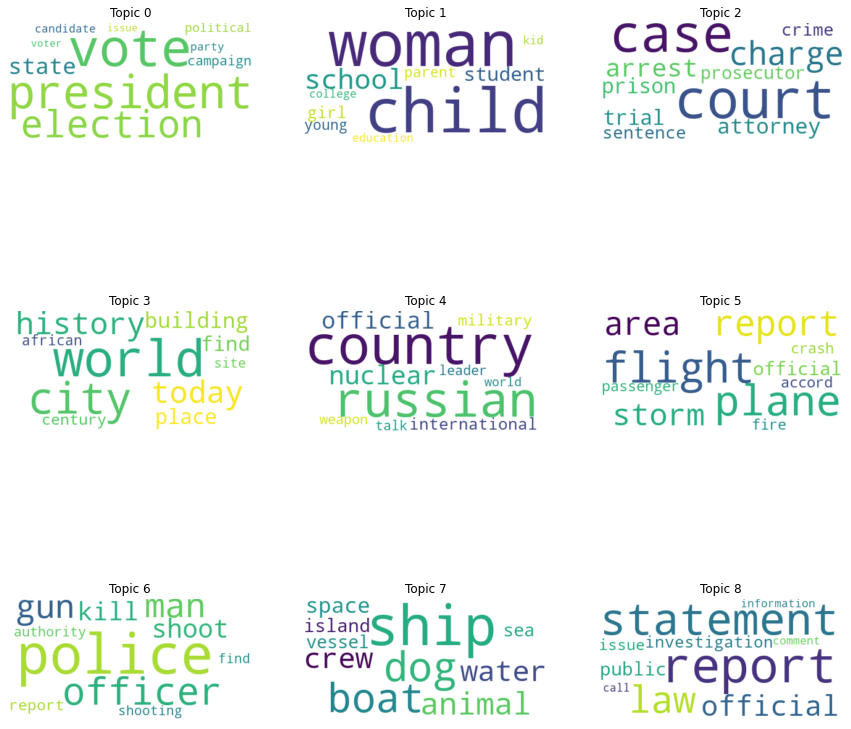

In [41]:
# Here we'll visualize the first nine topics.
render_word_cloud(lda_model, 3, 3, 10)

## Finding similar documents

In [42]:
lda_index = similarities.MatrixSimilarity(lda_model[corpus_bow_w_pos_filtered], num_features=len(dictionary_w_pos))

In [43]:
def get_similar_articles(index, model, article_bow, top_n=5, first_m_words=300):
  # model[article_bow] retrieves the topic distribution for the BOW.
  # index[model[article_bow] compares the topic distribution for the BOW against the similarity index previously computed.
  similar_docs = index[model[article_bow]]
  top_n_docs = sorted(enumerate(similar_docs), key=lambda item: -item[1])[1:top_n+1]
  
  # Return a list of tuples with each tuple: (article id, similarity score, first_m_words of article)
  return list(map(lambda entry: (entry[0], entry[1], articles[entry[0]][:first_m_words]), top_n_docs))

In [44]:
article_idx = 0
print(dataset[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])

 -- Children in war-ravaged Afghanistan are safer than those growing up in London or New York, NATO's top civilian envoy says.

Mark Sedwill, the senior civilian representative for NATO, made the comments on an episode of CBBC's "Newsround," which is airing Monday.

In the show -- a BBC current-affa 



[(12302,
  0.97341263,
  '\nMore than 11,000 children have been killed in the nearly three-year civil war in Syria, including young boys and girls who were tortured and executed, according to a report from a London-based think tank.\n\nThe Oxford Research Group said that most of the 11,420 children reported dead were killed in '),
 (13969,
  0.96700454,
  '\nChildren as young as 10 years old increasingly face horrific abuse in war-torn Somalia as the Islamist militant group Al-Shabaab has targeted them to replenish its diminishing ranks of fighters, according to a Human Rights Watch report released Tuesday.\n\nWhile the recruitment of child soldiers by t'),
 (10064,
  0.9649981,
  '\n -- Somalia\'s Al-Shabaab has brushed aside accusations from Human Rights Watch that the Islamist militia recruits child soldiers, saying that Islam considers people to be adults from the age of 15.\n\n"The allegations from Human Rights Watch say that Al-Shabaab recruits young children at the age of 1'),
 

In [45]:
article_idx = 10
print(dataset[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])


 -- The House Republican leadership upped the ante Thursday in the ongoing debate over the size and scope of the federal budget, unveiling a proposal to cut spending by $375 billion over the next five years.

House GOP Minority Whip Eric Cantor has been an outspoken critic of Democratic budget prop 



[(6590,
  0.9976947,
  "\n -- More than one speaker at the Democratic National Convention alleged this week that a Mitt Romney presidency would spell financial ruin for Medicare in four years.\n\nThe claim stems from earlier projections, made before the Democrats' health care reform law was passed in 2010, that Medicare's hos"),
 (7271,
  0.9972144,
  '\n -- House Budget Chairman Paul Ryan, R-Wisconsin, will unveil a highly anticipated 2012 Republican budget next week that proposes dramatic changes to political lightning rods: entitlements.\n\nThe plan, to be released Tuesday, calls for a controversial overhaul of Medicare, the health care program fo'),
 (12924,
  0.99598736,
  '\n -- As the Supreme Court prepares to hear arguments in the constitutionality of the health care reform law, CNN spoke with two experts on opposing sides of the issue.\n\nKaren Harned is executive director of Small Business Legal Center for the National Federation of Independent Business. The group, a'),
 (280

In [46]:
article_idx = 100
print(dataset[article_idx][:snippet_length], '\n')
get_similar_articles(lda_index, lda_model, corpus_bow_w_pos_filtered[article_idx])


 -- A tip led to Wednesday's arrest in Louisiana of a suspected serial bank robber dubbed the "Granddad Bandit," federal authorities said.

Michael Francis Mara, 52, was captured at his home in Baton Rouge, FBI Special Agent Sheila Thorne told CNN.

The FBI went to the residence to execute an arres 



[(18369,
  0.97382927,
  "\n -- More than 250 illegal guns have been seized by the New York City Police Department in the largest gun bust in the city's history, Mayor Michael Bloomberg announced Monday.\n\nThe guns were smuggled into New York City from North Carolina and South Carolina between September 2012 and July 2013 thro"),
 (6968,
  0.9708811,
  "\n -- An Australian businessman pleaded guilty Thursday to strapping a fake bomb around an 18-year-old girl's neck in an attempt to extort money from her family, a court representative said.\n\nThe guilty plea by Paul Douglas Peters at Sydney Central Local Court is the latest development in a case that"),
 (17704,
  0.97021896,
  '\nA West Virginia man who fatally shot four people and then himself was apparently disappointed with people in his life, including his ex-girlfriend, Monongalia County Sheriff Kenneth "Al" Kisner told CNN on Tuesday.\n\nOn Monday, Jody Lee Hunt, 39, of Westover, killed his ex, a man she was having a re'),
 (9

In [47]:
test_article = "Capricorn Business Acquisitions Inc. (TSXV: CAK.H) (the “Company“) is pleased to announce that its board has approved the issuance of 70,000 stock options (“Stock Options“) to directors on April 19, 2020."

article_tokens = list(map(improved_filter, [nlp(test_article)]))[0]
article_bow = dictionary_w_pos.doc2bow(article_tokens)
get_similar_articles(lda_index, lda_model, article_bow)

[(12158,
  0.9948252,
  '\n -- Almost hidden in the spectacular red rock country of northwestern New Mexico is a tiny charity that educates and houses almost 200 Native American children and their families.\n\nThe St. Bonaventure Indian Mission and School, affiliated with the Roman Catholic Diocese of Gallup, mostly survives o'),
 (12542,
  0.9926583,
  '\n -- A British parliamentary report slammed Barclays bank on Saturday for its "disgraceful" actions that led to a rate-rigging scandal.\n\nThe Treasury Select Committee issued a report after recent hearings over the scandal. Barclays was fined $450 million by British and American regulators after some'),
 (10769,
  0.99243593,
  '\n -- Nobel Laureate and microfinance pioneer Muhammad Yunus faced a new government fight Monday as the Cabinet ordered "legal action" against him for what it called "tax irregularities."\n\nThe Cabinet meeting, led by Prime Minister Sheikh Hasina, discussed a report prepared by the National Board of R'),
 (9

In [48]:
test_article = "DEA agent sentenced to 12 years in prison for conspiring with Colombian drug cartel."

article_tokens = list(map(improved_filter, [nlp(test_article)]))[0]
article_bow = dictionary_w_pos.doc2bow(article_tokens)
get_similar_articles(lda_index, lda_model, article_bow)

[(4232,
  0.99858594,
  "\n -- A former federal prosecutor was arrested Wednesday on charges related to the murder of a witness in a drug case, among many other counts, the U.S. Attorney's Office in Newark, New Jersey, said.\n\nFormer federal prosecutor Paul Bergrin is charged with leading a racketeering conspiracy that includ"),
 (6838,
  0.99837494,
  '\n -- After nearly 21 hours of deliberations, the jury in the trial of former Penn State assistant football coach Jerry Sandusky reached a verdict Friday night. It found him guilty of 45 of 48 counts.\n\nThere originally were 52 charges against Sandusky. On Thursday, Judge John Cleland announced that t'),
 (18431,
  0.9975618,
  '\nLess than a week after drug lord Rafael Caro Quintero was released from prison because of procedural errors, the Mexican government wants him locked up.\n\nThe office of the Mexican attorney general late Wednesday said that it has issued a warrant for "provisional detention," acting on a request from'),
 (85